In [4]:
import datasets as ds
import utils as ut
import models as md

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import skfuzzy as fuzz


# fairlearn
from fairlearn.postprocessing import ThresholdOptimizer
from xgboost import XGBClassifier
import fasttext

# libs 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import ShuffleSplit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1: Auditing with repsect to stereotypes 

In [5]:
rep = "WE"
ft = fasttext.load_model('cc.en.300.bin')
occupation = "attorney"
all_dataset = ds.Dataset('biasbios', target_occ=occupation, rep=rep)
all_dataset.split_train_test()
print(len(all_dataset.y_train))
occ_dataset = ds.Dataset('biasbios', target_occ=occupation, rep=rep, balanced=True)
occ_dataset.split_train_test()
print(len(occ_dataset.y_train))

generating fast text vectors


46878it [00:10, 4515.90it/s]


32814
generating fast text vectors


8860it [00:02, 3335.20it/s]


6202


In [6]:
# base predictor 
clf = LogisticRegression()
clf.fit(occ_dataset.x_train, occ_dataset.y_train)

p = clf.predict_proba(occ_dataset.x_test)[:, 1]
p_acc = accuracy_score(occ_dataset.y_test, p > 0.5)

mask = occ_dataset.g_test == 0
male_acc = accuracy_score(occ_dataset.y_test[mask], p[mask] > 0.5)
female_acc = accuracy_score(occ_dataset.y_test[~mask], p[~mask] > 0.5)

print(f"base clf acc: {p_acc:.3f} male acc: {male_acc:.3f} female acc: {female_acc:.3f}")

base clf acc: 0.886 male acc: 0.882 female acc: 0.888


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
g_clf = LogisticRegression()
g_clf.fit(occ_dataset.x_train, occ_dataset.g_train)
g_occ_pred = g_clf.predict_proba(occ_dataset.x_test)[:, 1]
print(f"clf g_occ acc: {accuracy_score(occ_dataset.g_test, 
                                       g_clf.predict(occ_dataset.x_test)):.3f}")

occ_clf = LogisticRegression()
occ_clf.fit(all_dataset.x_train, all_dataset.g_train)
g_all_pred = occ_clf.predict_proba(all_dataset.x_test)[:, 1]
print(f"clf g acc: {accuracy_score(all_dataset.g_test, 
                                  occ_clf.predict(all_dataset.x_test)):.3f}")

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf g_occ acc: 0.662
clf g acc: 0.661


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


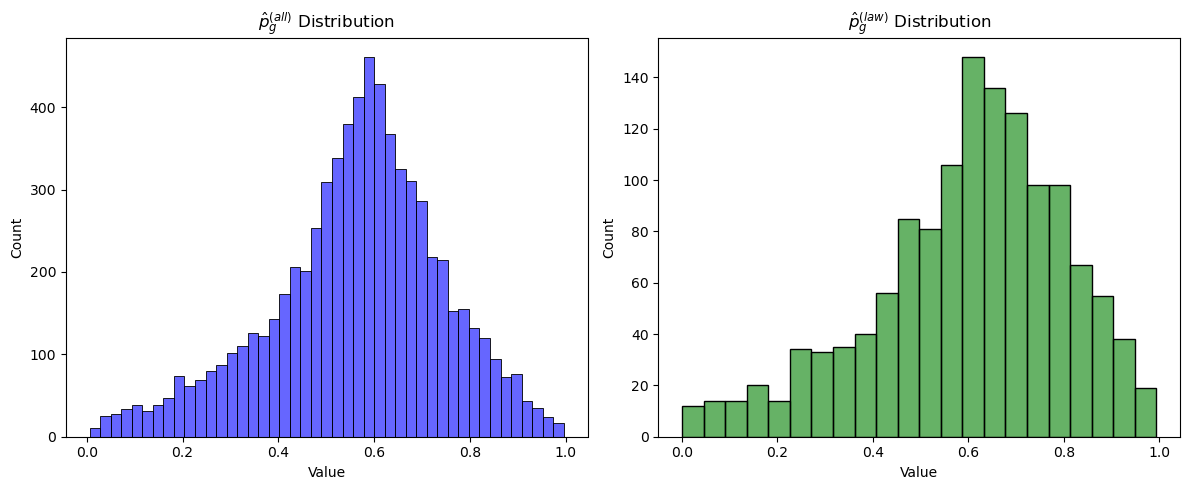

In [18]:
plt.figure(figsize=(12, 5))

# First histogram
plt.subplot(1, 2, 1)
sns.histplot(data=g_all_pred, color='blue', alpha=0.6)
plt.title(r'$\hat{p}_g^{(all)}$ Distribution')
plt.xlabel('Value')
plt.ylabel('Count')

# Second histogram
plt.subplot(1, 2, 2)
sns.histplot(data=g_occ_pred, color='green', alpha=0.6)
plt.title(r'$\hat{p}_g^{(law)}$ Distribution')
plt.xlabel('Value')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [215]:
# PCA Benchmark
for n_dim in [2, 4, 8, 16, 32, 64, 128, 256, 300]: 
    pca = PCA(n_components=n_dim)
    x = pca.fit_transform(occ_dataset.x_train)
    g_clf = LogisticRegression()
    g_clf.fit(x, occ_dataset.g_train)
    print(f"g dim {n_dim} acc: {accuracy_score(occ_dataset.g_test, 
                                              g_clf.predict(pca.transform(occ_dataset.x_test))):.3f}")

g dim 2 acc: 0.567
g dim 4 acc: 0.571
g dim 8 acc: 0.578
g dim 16 acc: 0.576
g dim 32 acc: 0.613
g dim 64 acc: 0.633
g dim 128 acc: 0.648


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


g dim 256 acc: 0.658
g dim 300 acc: 0.657


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
def find_means(input_x, input_g, n_dim=2): 
    # hard coded gender dimensions
    gendered_word_list = [('man', 'woman'), 
                      ('men', 'women'),
                      ('he', 'she'),
                      ('boy', 'girl'),
                      ('king', 'queen'),
                      ('male', 'female'), 
                      ('son', 'daughter'), 
                      ('himself', 'herself'),
                      ('his', 'hers'), 
                      ('guy', 'gal'), 
                      ('father', 'mother'), 
                     ]

    top_diff_dim = []
    for word1, word2 in gendered_word_list: 
        m = ft.get_word_vector(word1)
        f = ft.get_word_vector(word2)
        diff_vec = f-m
        top_diff_dim.append(np.argsort(diff_vec)[:5]) #[::-1][:10])
    
    vals, cnts = np.unique(np.concatenate(top_diff_dim), return_counts=True)
    ind = vals[np.argsort(cnts)[::-1]][:n_dim]
    x = input_x[:, ind]

    mask = input_g == 0 
    group1_mean = np.mean(x[mask], axis=0)
    mask = input_g == 1 
    group2_mean = np.mean(x[mask], axis=0)

    empirical_means = np.vstack([group1_mean, group2_mean]).T
    return empirical_means, ind 

def infer_fuzzy(input_data, ind, cntr, n_dim=2): 
    print(input_data[:, ind].T.shape, cntr.shape)
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
        test_data=input_data[:, ind].T, # S x c 
        cntr_trained=cntr, # S x c
        m=2, 
        error=0.005, 
        maxiter=1000)
    return u

In [21]:
# stereotype predictors:
# 1) overall pg
all_pg_clf = LogisticRegression()
all_pg_clf.fit(all_dataset.x_train, all_dataset.g_train)
all_pg = all_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

# 2) professor pg
occ_pg_clf = LogisticRegression()
occ_pg_clf.fit(occ_dataset.x_train, occ_dataset.g_train)
occ_pg = occ_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

# 4) clustering 
cntr, ind = find_means(input_x=occ_dataset.x_train, 
                  input_g=occ_dataset.g_train, 
                      n_dim=4)

# cluster_pg = infer_fuzzy(input_data=occ_dataset.x_test, 
#                         ind=ind, 
#                         cntr=cntr.T,
#                          n_dim=4)[1, :]

cluster_pg_clf = md.FuzzyClusterPredictor(cntr.T, ind)
cluster_pg = cluster_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [24]:
# evaluate stereotype predictors
# clf

results = {} 
p = clf.predict_proba(occ_dataset.x_test)[:, 1]
for pg, name in zip([all_pg, occ_pg, cluster_pg], 
                    ['all_pg', 'occ_pg', 'cluster_pg']): 
    print(name)
    # group prediction accuracy
    print(f"acc {accuracy_score(occ_dataset.g_test, pg>0.5):.3f}")
    print('cov(y, pg)', ut.emp_cov(occ_dataset.y_test, pg))
    print('corr(y, pg)', stats.pearsonr(occ_dataset.y_test, pg))
    print('cov(p, pg)', ut.emp_cov(p, pg))
    print('corr(p, pg)', stats.pearsonr(p, pg))
    results[name] = {} 
    results[name]['DP'] = ut.emp_cov(p, pg)
    results[name]['DP_corr'] = stats.pearsonr(p, pg)


    mask = occ_dataset.y_test == 1 
    print('cov(p, pg | y=1)', ut.emp_cov(p[mask], pg[mask]))
    print('corr(p, pg | y=1)', stats.pearsonr(p[mask], pg[mask]))
    results[name]['EO'] = ut.emp_cov(p[mask], pg[mask])
    results[name]['EO_corr'] = stats.pearsonr(p[mask], pg[mask])

    results[name]['MA'] = np.abs(ut.emp_cov(p, pg) - ut.emp_cov(occ_dataset.y_test, pg))

all_pg
acc 0.667
cov(y, pg) 0.009689361626383683
corr(y, pg) PearsonRResult(statistic=0.11225484680274728, pvalue=4.10622866606676e-05)
cov(p, pg) 0.00904758213514001
corr(p, pg) PearsonRResult(statistic=0.12455106915680263, pvalue=5.2626243673406675e-06)
cov(p, pg | y=1) 0.003072632922174504
corr(p, pg | y=1) PearsonRResult(statistic=0.07779978307074249, pvalue=0.04506779820868533)
occ_pg
acc 0.662
cov(y, pg) 0.014622843713155465
corr(y, pg) PearsonRResult(statistic=0.14409625394199738, pvalue=1.3224565597652938e-07)
cov(p, pg) 0.014495090454538841
corr(p, pg) PearsonRResult(statistic=0.16972537273839203, pvalue=4.759908333942875e-10)
cov(p, pg | y=1) 0.003766404740039733
corr(p, pg | y=1) PearsonRResult(statistic=0.07992611143391297, pvalue=0.039497484559052005)
cluster_pg
acc 0.546
cov(y, pg) 0.002081671721296962
corr(y, pg) PearsonRResult(statistic=0.07867174519395573, pvalue=0.004107781423798011)
cov(p, pg) 0.0009709104958655509
corr(p, pg) PearsonRResult(statistic=0.0436004254138

## Demographic Parity

In [45]:
DP_plot = [] 

In [71]:
# DP Post Processing
dataset = occ_dataset

#clf_list = [all_pg_clf]
#clf_list_name = r'$\hat{p}_g^{(all)}$'
#clf_list_name = r'$\hat{p}_g^{(law)}$'
#clf_list_name = r'$\hat{p}_g^{(FCM)}$'
clf_list_name = r'$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$'

# all pg one time: 
# 2a) overall pg
all_pg_clf = LogisticRegression()
all_pg_clf.fit(all_dataset.x_train, all_dataset.g_train)

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

i = 0 
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = occ_dataset.x_train[train_idx]
    y_train_sub = occ_dataset.y_train[train_idx]
    g_train_sub = occ_dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)


    # 2b) professor pg
    occ_pg_clf = LogisticRegression()
    occ_pg_clf.fit(x_train_sub, g_train_sub)
    occ_pg = occ_pg_clf.predict_proba(x_train_sub)[:, 1]
    
    # 2c) clustering 
    cntr, ind = find_means(input_x=x_train_sub, 
                      input_g=g_train_sub, 
                          n_dim=4)
    
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr.T, ind)
    cluster_pg = cluster_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]


    pg_dict = {'all_pg': all_pg_clf,
               'occ_pg': occ_pg_clf,
               'cluster_pg': cluster_pg_clf}
    
    
    prev_results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=occ_dataset.x_test, 
                            y=occ_dataset.y_test, 
                            g=occ_dataset.g_test)

    if clf_list_name == r'$\hat{p}_g^{(FCM)}$': 
        for key in pg_dict.keys(): 
            DP_plot.append({
                'eval_pg': key, 
                'intervention_pg': 'None', 
                'value': prev_results[f'cov(p, {key})'], 
                'run': i, 
                'acc': prev_results['accuracy'], 
            })
    
    #clf_list = [occ_pg_clf]
    clf_list = [cluster_pg_clf, occ_pg_clf, all_pg_clf]
    c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
    md.fit_dp_pg_multi(x=x_train_sub, 
                   multi_clf=c_post_processed, 
                   alpha=1e-4)
    
    results = ut.results_summary(p=c_post_processed.predict_proba_1d(dataset.x_test), 
                            pg_dict=pg_dict, 
                            x=occ_dataset.x_test, 
                            y=occ_dataset.y_test, 
                            g=occ_dataset.g_test)
    for key in pg_dict.keys(): 
        DP_plot.append({
            'eval_pg': key, 
            'intervention_pg': f'DP wrt. {clf_list_name}', 
            'value': results[f'cov(p, {key})'], 
            'acc': results['accuracy'], 
            'run': i, 
        })

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [69]:
sns.set_theme()

In [86]:
plot_df = pd.DataFrame(DP_plot)
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'occ_pg': r'$\hat{p}_g^{(law)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['eval_pg'] = plot_df['eval_pg'].map(plot_map)
acc_dict=plot_df.groupby("intervention_pg")['acc'].mean().to_dict()

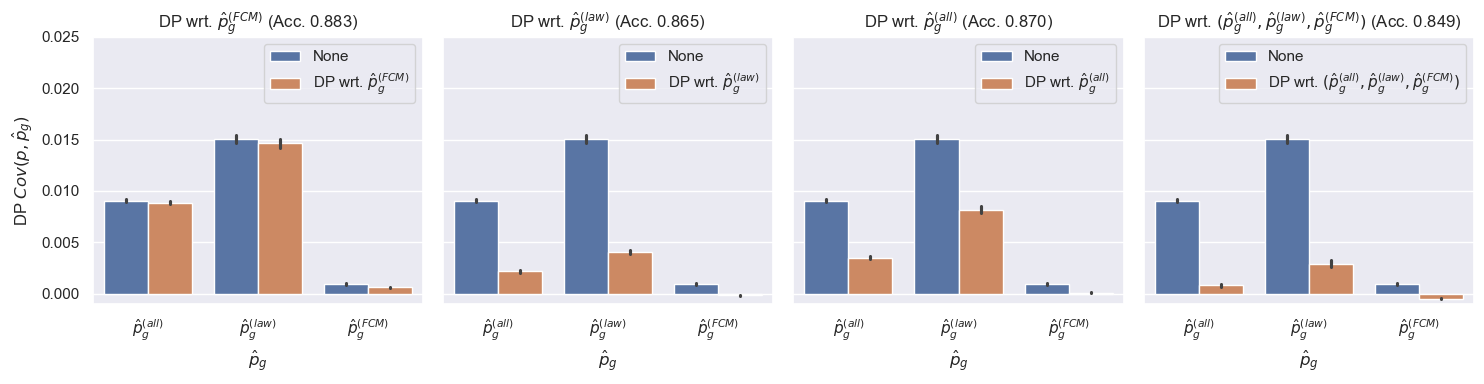

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df['intervention_pg'].value_counts().index[1:]): 
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df['intervention_pg'].isin([key, 'None'])]
    sns.barplot(data=subplot_df, x='eval_pg', y='value', hue='intervention_pg', ax=ax)
    ax.legend(title=None, loc='upper right')
    ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r'$\hat{p}_g$')
    ax.set_ylabel(r'DP $Cov(p, \hat{p}_g)$') 
    ax.set_title(f'{key} (Acc. {acc_dict[key]:.3f})')

plt.tight_layout()
plt.savefig('img/bios/dp_all_bios.pdf')

## Equal Opportunity

In [98]:
EO_plot = [] 

In [103]:
# DP Post Processing
dataset = occ_dataset
#clf_list = [all_pg_clf]
#clf_list_name = r'$\hat{p}_g^{(all)}$'
#clf_name = 'all_pg'
#clf_list_name = r'$\hat{p}_g^{(law)}$'
#clf_list_name = r'$\hat{p}_g^{(FCM)}$'

clf_list_name = r'$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$'
# all pg one time: 
# 2a) overall pg
all_pg_clf = LogisticRegression()
all_pg_clf.fit(all_dataset.x_train, all_dataset.g_train)

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
acc_list = [] 

i = 0 
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = occ_dataset.x_train[train_idx]
    y_train_sub = occ_dataset.y_train[train_idx]
    g_train_sub = occ_dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)


    # 2b) professor pg
    occ_pg_clf = LogisticRegression()
    occ_pg_clf.fit(x_train_sub, g_train_sub)
    occ_pg = occ_pg_clf.predict_proba(x_train_sub)[:, 1]
    
    # 2c) clustering 
    cntr, ind = find_means(input_x=x_train_sub, 
                      input_g=g_train_sub, 
                          n_dim=4)
    
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr.T, ind)
    cluster_pg = cluster_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

    pg_dict = {'all_pg': all_pg_clf,
               'occ_pg': occ_pg_clf,
               'cluster_pg': cluster_pg_clf}
    
    
    prev_results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=occ_dataset.x_test, 
                            y=occ_dataset.y_test, 
                            g=occ_dataset.g_test)

    if clf_list_name == r'$\hat{p}_g^{(FCM)}$': 
        for key in pg_dict.keys(): 
            EO_plot.append({
                'eval_pg': key, 
                'intervention_pg': 'None',  
                'value': np.abs(prev_results[f'cov(p, {key} |y=1)']), 
                'run': i, 
                'acc': prev_results['accuracy'], 
            })

    #clf_list = [occ_pg_clf]
    #clf_list = [cluster_pg_clf]
    clf_list = [all_pg_clf, occ_pg_clf, cluster_pg_clf]
    #clf_name = '3_pgs'
    #clf_list = [cluster_pg_clf]
    #clf_name = 'cluster'
    
    eo_clf = md.EOClf(base_clf=clf, pg_clf_list=clf_list)
    eo_clf.fit_exact(x=x_train_sub, y=y_train_sub)

    #results = ut.results_summary(p=eo_clf.predict_proba(dataset.x_test)[:, 1], 
    # c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
    # md.fit_dp_pg_multi(x=x_train_sub, 
    #                multi_clf=c_post_processed, 
    #                alpha=1e-4)
    
    results = ut.results_summary(p=eo_clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=occ_dataset.x_test, 
                            y=occ_dataset.y_test, 
                            g=occ_dataset.g_test)
    for key in pg_dict.keys(): 
        EO_plot.append({
            'eval_pg': key, 
            'intervention_pg': f'EO wrt. {clf_list_name}', 
            'value': np.abs(results[f'cov(p, {key} |y=1)']),
            'acc': results['accuracy'], 
            'run': i, 
        })

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

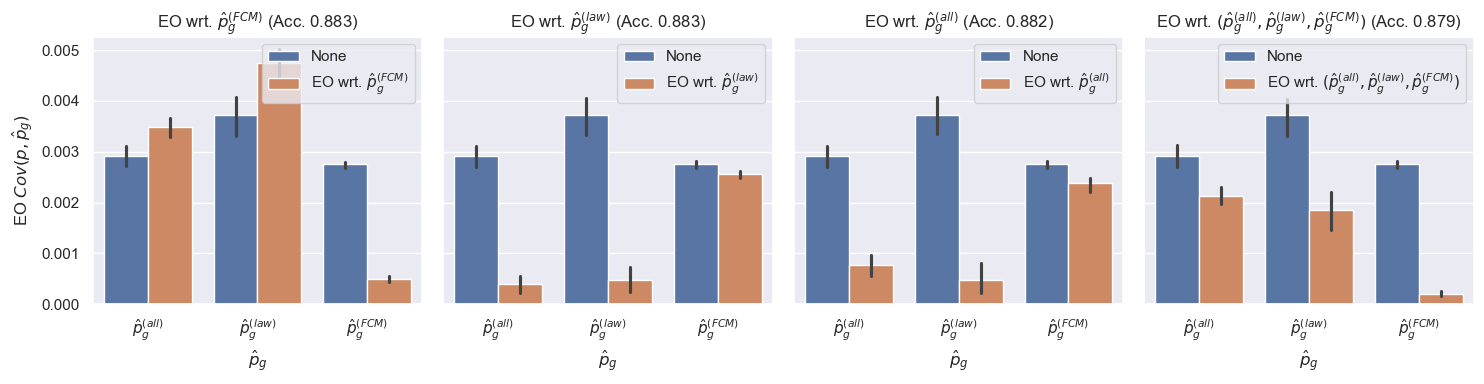

In [105]:
plot_df = pd.DataFrame(EO_plot)
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'occ_pg': r'$\hat{p}_g^{(law)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['eval_pg'] = plot_df['eval_pg'].map(plot_map)
acc_dict=plot_df.groupby("intervention_pg")['acc'].mean().to_dict()

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df['intervention_pg'].value_counts().index[1:]): 
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df['intervention_pg'].isin([key, 'None'])]
    sns.barplot(data=subplot_df, x='eval_pg', y='value', hue='intervention_pg', ax=ax)
    ax.legend(title=None, loc='upper right')
    #ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r'$\hat{p}_g$')
    ax.set_ylabel(r'EO $Cov(p, \hat{p}_g)$') 
    ax.set_title(f'{key} (Acc. {acc_dict[key]:.3f})')

plt.tight_layout()
plt.savefig('img/bios/eo_all_bios.pdf')


status
EO wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$    0.880211
original                                                               0.884876
Name: acc, dtype: float64


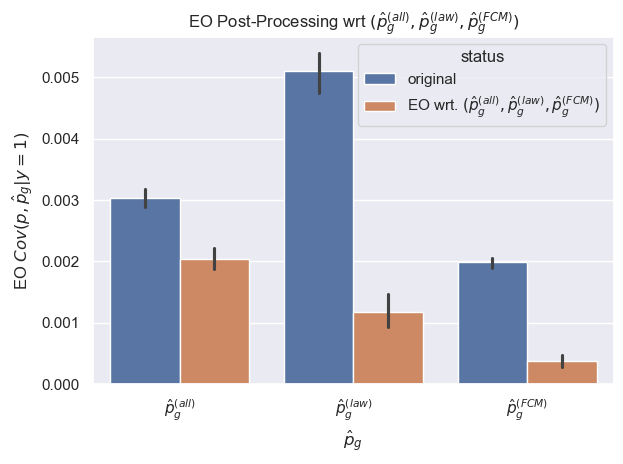

In [432]:
plot_df = pd.DataFrame(DP_plot)
print(plot_df.groupby("status")['acc'].mean())
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'occ_pg': r'$\hat{p}_g^{(law)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['pg'] = plot_df['pg'].map(plot_map)

sns.barplot(data=plot_df, x='pg', y='value', hue='status')
plt.xlabel(r'$\hat{p}_g$')
plt.ylabel(r'EO $Cov(p, \hat{p}_g | y=1)$') 
plt.title(f'EO Post-Processing wrt {clf_list_name}')
plt.tight_layout()
#plt.savefig(f'img/eo_{clf_name}.pdf')

In [297]:
plot_df = [] 
pg_clf_dict = {} 
for i in range(len(dataset.class_map)): 
    p = clf.predict_proba(dataset.x_test)[:, 1]
    #pg_clf = LogisticRegression()
    mask = dataset.y_all_train == i 
    pg_clf.fit(dataset.x_train[mask], dataset.g_train[mask])
    pg = pg_clf.predict_proba(dataset.x_test)[:, 1]
    mask = dataset.y_all_test == i 
    clf_acc = accuracy_score(dataset.g_test[mask], pg_clf.predict(dataset.x_test[mask]))
    print(f"{dataset.reverse_class_map[i]} acc: {clf_acc} cov(p, pg) {ut.emp_cov(p, pg)}")
    if clf_acc > 0.6: 
        plot_df.append({'cov(y, pg)': ut.emp_cov(dataset.y_test, pg), 
                        'cov(g, pg)': ut.emp_cov(dataset.g_test, pg),
                        'corr(y, pg)': stats.pearsonr(dataset.y_test, pg)[0], 
                        'corr(g, pg)': stats.pearsonr(dataset.g_test, pg)[0],
                        'corr(p, pg)': stats.pearsonr(p, pg)[0],
                        'cov(p, pg)': ut.emp_cov(p, pg), 
                        'pg': dataset.reverse_class_map[i]})
        pg_clf_dict[dataset.reverse_class_map[i]] = pg_clf
    
pg_all_clf = LogisticRegression()
pg_all_clf.fit(dataset.x_train, dataset.g_train)
pg_all_clf.predict_proba(dataset.x_test)[:, 1]
plot_df.append({'cov(y, pg)': ut.emp_cov(dataset.y_test, pg), 
                'cov(g, pg)': ut.emp_cov(dataset.g_test, pg),
                'corr(y, pg)': stats.pearsonr(dataset.y_test, pg)[0], 
                'corr(g, pg)': stats.pearsonr(dataset.g_test, pg)[0],
                'corr(p, pg)': stats.pearsonr(p, pg)[0],
                'cov(p, pg)': ut.emp_cov(p, pg),
                'pg': "all"})
pg_clf_dict['all'] = pg_all_clf
print(f"pg all {accuracy_score(dataset.g_test, pg_all_clf.predict(dataset.x_test))}")
plot_df = pd.DataFrame(plot_df)

ValueError: X has 5000 features, but LogisticRegression is expecting 300 features as input.

In [6]:
# Get the feature names and coefficients

feature_names = dataset.vectorizer.get_feature_names_out()
coefficients = pg_clf_dict['professor'].coef_[0]

# Sort the coefficients and feature names together
sorted_coefficients = sorted(zip(coefficients, feature_names), reverse=True)

# Print the most positive and negative features
print("Most positive features:")
for coef, feature_name in sorted_coefficients[:10]:
    print(f"{feature_name}: {coef:.4f}")

print("\nMost negative features:")
for coef, feature_name in sorted_coefficients[-10:]:
    print(f"{feature_name}: {coef:.4f}")

Most positive features:
women: 2.5719
feminist: 2.3448
husband: 2.1657
max: 2.0570
fashion: 1.7585
participant: 1.7500
apa: 1.6765
breast: 1.5961
1985: 1.5691
girls: 1.5598

Most negative features:
method: -1.4025
football: -1.4139
inner: -1.4187
benefit: -1.4236
lgbtq: -1.5444
express: -1.5469
clinicians: -1.5871
meet: -1.6806
theology: -1.7002
wife: -2.5381


In [7]:
plot_list = ['comedian', 'dj', 'personal_trainer', 'physician',
 'professor', 'nurse', 'software_engineer', 'model', 'surgeon', 'photographer',
 'accountant', 'chiropractor', 'filmmaker', 'pastor', 'attorney', 'all']

In [8]:
def scatter_w_labels(plot_df, x_feat, y_feat): 
    sns.scatterplot(data=plot_df, x=x_feat, y=y_feat)
    for row in plot_df.iterrows():
        x = row[1][x_feat]
        y = row[1][y_feat]

        label = row[1]['pg']
        plt.text(x, y +0.0005, label, fontsize=12, ha='center', va='bottom')

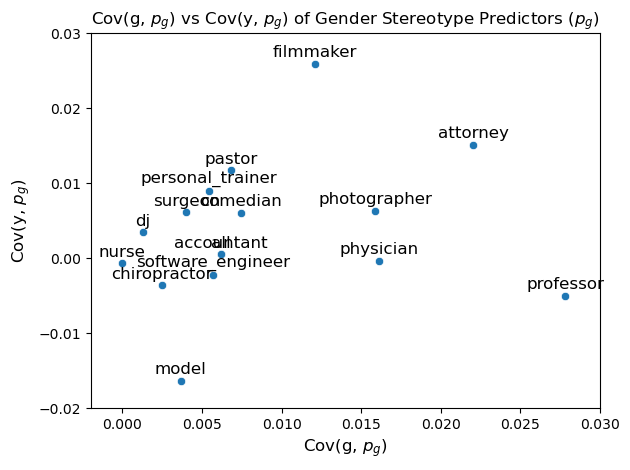

In [9]:
scatter_w_labels(plot_df[plot_df['pg'].isin(plot_list)], 
                 x_feat='cov(g, pg)',y_feat='cov(y, pg)')
plt.title(r"Cov(g, $p_g$) vs Cov(y, $p_g$) of Gender Stereotype Predictors ($p_g$)")
plt.ylabel(r"Cov(y, $p_g$)", fontsize=12)
plt.xlabel(r"Cov(g, $p_g$)", fontsize=12)
plt.xlim(-0.002, 0.03)
plt.ylim(-0.02, 0.03)
plt.tight_layout()
plt.savefig(f"bio-pgs-{rep}.pdf")

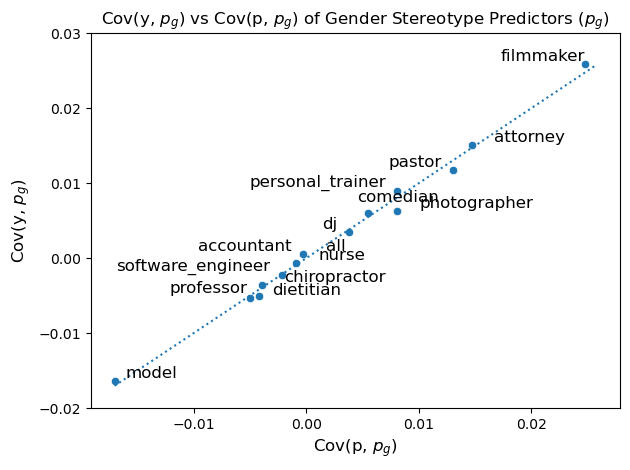

In [10]:
plot_list = ['comedian', 'dj', 'personal_trainer', 
 'professor', 'nurse', 'software_engineer', 'model', 'photographer',
 'accountant', 'chiropractor', 'filmmaker', 'dietitian', 'pastor', 'attorney', 'all']

df = plot_df[plot_df['pg'].isin(plot_list)]
df = df.sort_values(by='cov(p, pg)')
x_feat='cov(p, pg)'
y_feat='cov(y, pg)'

sns.scatterplot(data=df, x=x_feat, y=y_feat)
for i, row in enumerate(df.iterrows()):
    x = row[1][x_feat]
    y = row[1][y_feat]

    label = row[1]['pg']
    if label == "model": 
        plt.text(x+0.001, y, label, fontsize=12, ha='left', va='bottom')
    elif label == "filmmaker": 
        plt.text(x, y, label, fontsize=12, ha='right', va='bottom')
    elif label == "comedian": 
        plt.text(x-0.001, y+0.001, label, fontsize=12, ha='left', va='bottom')
    elif i % 2 == 0: 
        plt.text(x-0.001, y, label, fontsize=12, ha='right', va='bottom')
    else: 
        plt.text(x+0.002, y, label, fontsize=12, ha='left', va='bottom')
        
        
# scatter_w_labels(plot_df[plot_df['pg'].isin(plot_list)], x_feat='cov(p, pg)',y_feat='cov(y, pg)')


x = np.linspace(np.min(plot_df['cov(p, pg)']), np.max(plot_df['cov(p, pg)'])+0.001, 10)
y = x
plt.plot(x, y, linestyle=":")
plt.title(r"Cov(y, $p_g$) vs Cov(p, $p_g$) of Gender Stereotype Predictors ($p_g$)")
plt.ylabel(r"Cov(y, $p_g$)", fontsize=12)
plt.xlabel(r"Cov(p, $p_g$)", fontsize=12)
plt.ylim(-0.02, 0.03)

plt.tight_layout()
plt.savefig(f"bio-amplification-{rep}.pdf")

In [106]:
dataset.x_train, dataset.x_test, dataset.y_train, dataset.g_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([0, 1, 0, ..., 1, 0, 1]),
 array([0, 1, 1, ..., 0, 0, 0]))

In [ ]:
# demographic parity
# base classifier
dataset = occ_dataset
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
all_results = []

i = 0 
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # Get the subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]
    clf = LogisticRegression()
    
    clf.fit(x_train_sub, y_train_sub)
    print("Base")
    p = clf.predict_proba(dataset.x_test)[:, 1]
    p_acc = accuracy_score(dataset.y_test, p > 0.5)

    results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                                pg1=pg_clf_dict['filmmaker'], 
                                pg2=pg_clf_dict['attorney'], 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
    results['clf'] = 'base'
    results['iter'] = i
    all_results.append(results)
    print("DP")
    postprocess_est = ThresholdOptimizer(
        estimator=clf, 
        constraints="demographic_parity", 
        objective='accuracy_score', 
        predict_method="predict", 
        flip =True
    )

    postprocess_est.fit(X=x_train_sub, 
                        y=y_train_sub,
                        sensitive_features=g_train_sub)

    results = ut.results_summary(p=postprocess_est.predict(dataset.x_test, sensitive_features=dataset.g_test), 
                                pg1=pg_clf_dict['filmmaker'], 
                                pg2=pg_clf_dict['attorney'], 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
    results['clf'] = 'DP'
    results['iter'] = i
    all_results.append(results)
    print("PP")
    for name in ['filmmaker', 'attorney']: 
        c_post_processed = md.MACov(base_clf=clf, pg_clf=pg_clf_dict[name])
        md.fit_pg_cont(p_x=x_train_sub, 
                       base_clf=c_post_processed, 
                       pg_clf=pg_clf_dict[name], 
                       alpha=1e-4)

        results = ut.results_summary(p=c_post_processed.predict_proba(dataset.x_test)[:, 1], 
                                pg1=pg_clf_dict['filmmaker'], 
                                pg2=pg_clf_dict['attorney'], 
                                    x=dataset.x_test, 
                                    y=dataset.y_test, 
                                    g=dataset.g_test)
        results['clf'] = name
        results['iter'] = i
        all_results.append(results)

In [111]:
df = pd.DataFrame(all_results)
df.to_csv(f"bios-dp-{rep}.csv")

In [63]:
df = pd.read_csv(f"bios-dp-{rep}.csv")
df.groupby("clf").mean()

,Unnamed: 0,accuracy,"cov(p, pg1)","cov(p, pg2)",DP,"cov(p, pg1 |y=1)","cov(p, pg2 |y=1)",EO,iter
clf,,,,,,,,,
DP,19.0,0.834670,-0.009643,-0.017192,0.008669,-0.006254,-0.019814,0.017399,4.5
attorney,21.0,0.818970,-0.008496,-0.000759,0.013038,-0.004624,-0.005603,0.006032,4.5
base,18.0,0.837457,-0.010371,-0.012888,0.001154,-0.006279,-0.015685,0.005035,4.5
filmmaker,20.0,0.834755,0.001783,-0.011075,0.003397,0.003408,-0.013314,0.005068,4.5


In [112]:
ordered = df.groupby("clf").mean().loc[["base", "DP", "filmmaker", "attorney"]]
ordered[["accuracy", "DP", "cov(p, pg1)", "cov(p, pg2)"]]

,accuracy,DP,"cov(p, pg1)","cov(p, pg2)"
clf,,,,
base,0.843103,0.006976,0.024721,0.014593
DP,0.838865,0.009100,0.027185,0.015170
filmmaker,0.807651,0.018454,0.005205,0.005947
attorney,0.840728,0.002606,0.020105,0.002294


In [113]:
ordered = df.groupby("clf").std().loc[["base", "DP", "filmmaker", "attorney"]]
ordered[["accuracy", "DP", "cov(p, pg1)", "cov(p, pg2)"]]

,accuracy,DP,"cov(p, pg1)","cov(p, pg2)"
clf,,,,
base,0.001841,0.003706,0.000166,0.000215
DP,0.001699,0.003728,0.000180,0.000525
filmmaker,0.001156,0.001732,0.000161,0.000130
attorney,0.001070,0.001990,0.000161,0.000267


In [ ]:
clf_list = [pg_clf_dict["attorney"], pg_clf_dict["filmmaker"]]
c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
md.fit_dp_pg_multi(x=dataset.x_train, 
               multi_clf=c_post_processed, 
               alpha=1e-4)
p_train = c_post_processed.predict_proba_1d(dataset.x_train)

print(f"acc: {accuracy_score(p_train>0.5, p_clf.predict(dataset.x_train))}")

results = ut.results_summary(clf=c_post_processed, 
                        pg1=pg_clf_dict['filmmaker'], 
                        pg2=pg_clf_dict['attorney'], 
                            x=dataset.x_test, 
                            y=dataset.y_test, 
                            g=dataset.g_test)
print(name, results)

In [114]:
# Equal Opportunity wrt Groups

    
all_results = []

i = 0 
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i+= 1
    # Get the subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]
    
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)

    p = clf.predict_proba(dataset.x_test)[:, 1]
    p_acc = accuracy_score(dataset.y_test, p > 0.5)
    print("clf_acc", p_acc)

    results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                                pg1=pg_clf_dict['filmmaker'], 
                                pg2=pg_clf_dict['attorney'], 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
    results['clf'] = 'base'
    results['iter'] = i
    all_results.append(results)

    postprocess_est = ThresholdOptimizer(
    estimator=clf, 
    constraints="true_positive_rate_parity", 
    objective='accuracy_score', 
    predict_method="predict", 
    flip =True
)

    postprocess_est.fit(X=x_train_sub, 
                        y=y_train_sub, 
                        sensitive_features=g_train_sub)

    results = ut.results_summary(p=postprocess_est.predict(dataset.x_test, sensitive_features=dataset.g_test), 
                                pg1=pg_clf_dict['filmmaker'], 
                                pg2=pg_clf_dict['attorney'], 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
    results['clf'] = 'EO'
    results['iter'] = i
    all_results.append(results)

    for name in ['filmmaker', 'attorney']: 
        eo_clf = md.EOClf(base_clf=clf, pg_clf_list=[pg_clf_dict[name]])
        eo_clf.fit_exact(x=x_train_sub, y=y_train_sub)

        results = ut.results_summary(p=eo_clf.predict_proba(dataset.x_test)[:, 1], 
                                pg1=pg_clf_dict['filmmaker'], 
                                pg2=pg_clf_dict['attorney'], 
                                    x=dataset.x_test, 
                                    y=dataset.y_test, 
                                    g=dataset.g_test)
        results['clf'] = name
        results['iter'] = i
        all_results.append(results)

/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clf_acc 0.840443686006826


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8435722411831627


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8397326507394767


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8454209328782708


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8449943117178612


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8434300341296929


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8431456200227532


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8421501706484642


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8439988623435722


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

clf_acc 0.8441410693970421


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
df = pd.DataFrame(all_results)
df.to_csv(f"bios-eo-{rep}.csv")

In [117]:
ordered = df.groupby("clf").mean().loc[["base", "EO", "filmmaker", "attorney"]]
ordered[["accuracy", "EO", "cov(p, pg1 |y=1)", "cov(p, pg2 |y=1)"]]

,accuracy,EO,"cov(p, pg1 |y=1)","cov(p, pg2 |y=1)"
clf,,,,
base,0.843103,0.013903,0.022185,0.010990
EO,0.841852,0.006567,0.024344,0.012246
filmmaker,0.840998,0.010244,0.003451,0.003081
attorney,0.775213,0.012531,0.010854,0.001304


In [118]:
ordered = df.groupby("clf").std().loc[["base", "EO", "filmmaker", "attorney"]]
ordered[["accuracy", "EO", "cov(p, pg1 |y=1)", "cov(p, pg2 |y=1)"]]

,accuracy,EO,"cov(p, pg1 |y=1)","cov(p, pg2 |y=1)"
clf,,,,
base,0.001841,0.008194,0.000347,0.000376
EO,0.002155,0.006171,0.000835,0.001137
filmmaker,0.001174,0.005309,0.000321,0.000328
attorney,0.057736,0.007030,0.004202,0.000914


In [ ]:
new_plot_df = [] 
for key, pg_clf in pg_clf_dict.items(): 
    pg = pg_clf.predict_proba(dataset.x_test)[:, 1]
    p = c_post_processed.predict_proba_1d(dataset.x_test)
    new_plot_df.append({'cov(y, pg)': ut.emp_cov(dataset.y_test, pg), 
                'cov(g, pg)': ut.emp_cov(dataset.g_test, pg),
                'corr(y, pg)': stats.pearsonr(dataset.y_test, pg)[0], 
                'corr(g, pg)': stats.pearsonr(dataset.g_test, pg)[0],
                'corr(p, pg)': stats.pearsonr(p, pg)[0],
                'cov(p, pg)': ut.emp_cov(p, pg), 
                'pg': key})
new_plot_df = pd.DataFrame(new_plot_df)


In [ ]:
print(accuracy_score(c_post_processed.predict(dataset.x_test), dataset.y_test))
print(accuracy_score(clf.predict(dataset.x_test), dataset.y_test))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(plot_df, x='cov(p, pg)', y='cov(y, pg)', ax=axes[0])
x = np.linspace(np.min(plot_df['cov(p, pg)']), np.max(plot_df['cov(p, pg)']), 10)
y = x
axes[0].plot(x, y, linestyle=":")
axes[0].set_title("No Multi-Accuracy")

sns.scatterplot(new_plot_df, x='cov(p, pg)', y='cov(y, pg)', ax=axes[1])
x = np.linspace(np.min(new_plot_df['cov(p, pg)']), np.max(new_plot_df['cov(p, pg)']), 10)
y = x
axes[1].plot(x, y, linestyle=":")
axes[1].set_title("Multi-Accuracy")